In [1]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os.path as op
import sys
sys.path.append("../")

from src import regmod
from src import utils
from src import solver

import importlib

## Synthetic Example

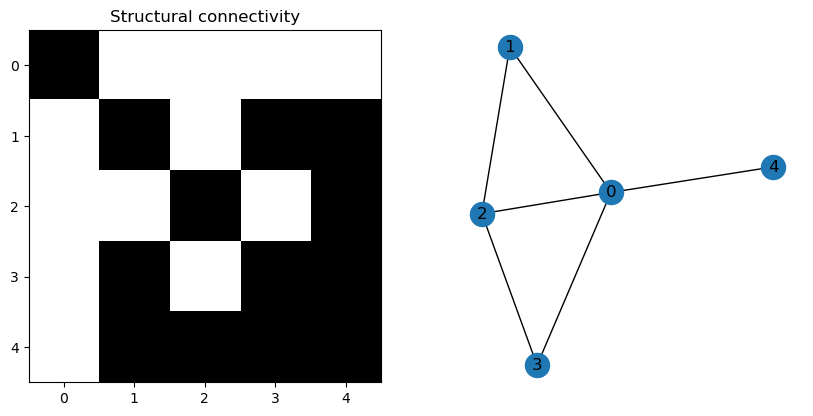

In [2]:
path_to_data = "../resources"
save_plots = False

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

filename = "adjacency_synthetic.pkl"

adj = utils.load(op.join(path_to_data, filename))
adj -= np.diag(np.diag(adj))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

### Example of a forward pass

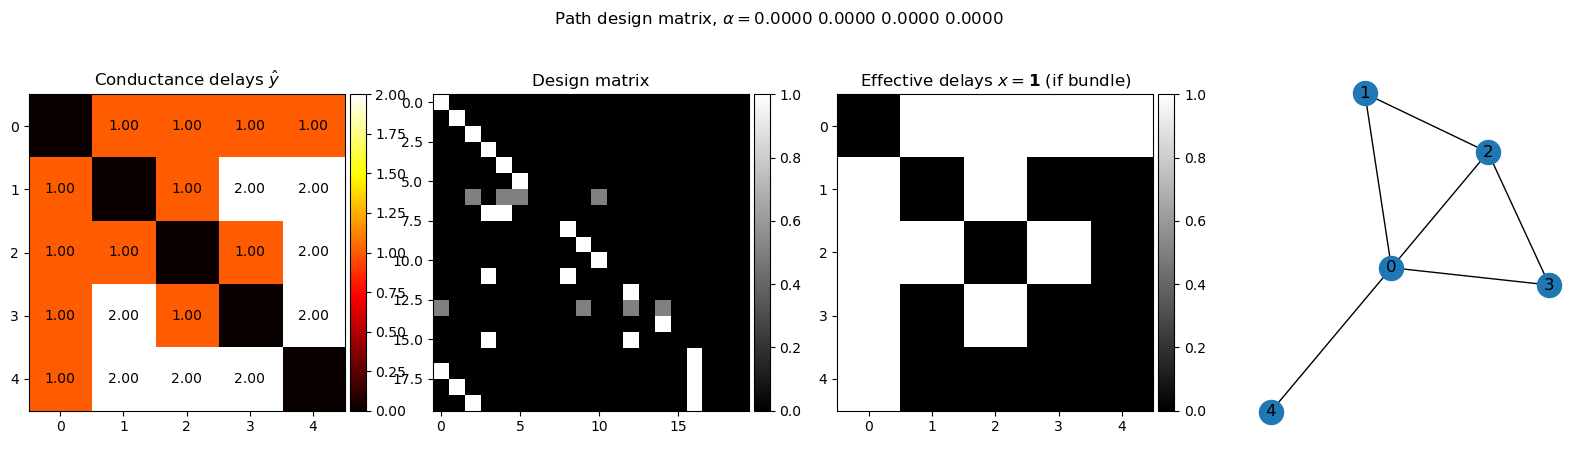

In [3]:
max_path_depth = 4

# multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

a = 0
# Computes the alpha vector as alpha_n = a^n
alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

# design_shortest = regmod.combine_paths_matrices(multi_hops_design, alpha=alpha)
design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=a)
design_model = design_shortest

y_pred_mat = regmod.predict_conduction_delays(design_model, adj, invert_weights=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(y_pred_mat, cmap='hot')
axes[0].set_title("Conductance delays $\hat{y}$")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], y_pred_mat, adapt_color=0.6)

axes[1].imshow(design_model, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title("Design matrix")
utils.add_cbar(fig, axes[1])

axes[2].imshow(adj, cmap='gray')#, vmax=y_pred_mat.max())
axes[2].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[2])

nx.draw(toy_graph, ax=axes[3], with_labels=True)

### Backward pass: Initialization with pseudo-inverse + iterative optimization

In [4]:
max_path_depth = 4

a = 0
alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=a)
design_model = design_shortest

x_ground = utils.remove_diagonal_entries(adj).flatten()

alpha = solver.torch.tensor(alpha)

design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)

y_pred = solver.forward(design_model, solver.torch.tensor(x_ground))
x_pseudo = solver.pseudo_inverse(y_pred.numpy(), a_design=design_model.numpy())

y_ground = solver.torch.tensor(utils.deepcopy(y_pred))
init_pseudo = False
if init_pseudo:
    x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
else:
    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(x_ground))).requires_grad_(True)

# alphas_init = solver.torch.tensor(np.random.rand(len(alpha))).requires_grad_(True)

/var/folders/nj/ltrlv15x5jj2jq78pbb2srz80000gn/T/ipykernel_76439/1241894738.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ground = solver.torch.tensor(utils.deepcopy(y_pred))


In [9]:
x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_ground, design_model,
                                            n_iter=10000, verbose=False, early_stop=1e-10, step_size=1e-2)

  0%|          | 0/10000 [00:00<?, ?it/s]

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Estimated Effective delays w/ loss=0.0013'}>)

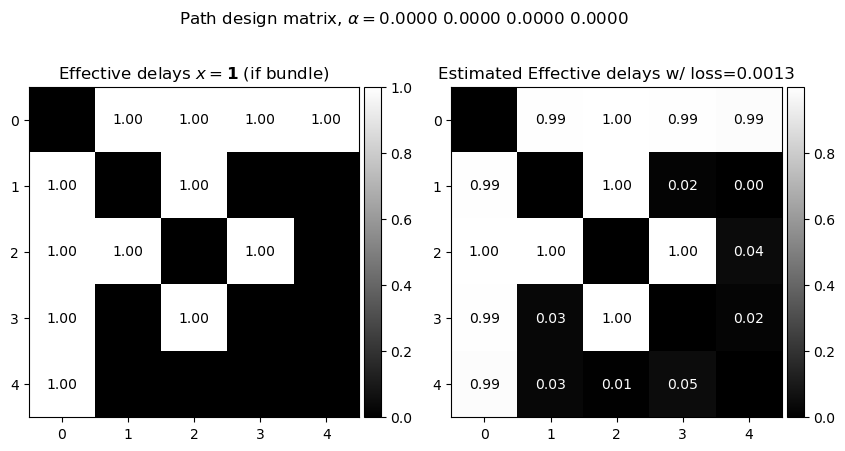

In [10]:
x_ground_mat = utils.add_diagonal_entries(x_ground.reshape(adj.shape[0], adj.shape[1]-1))
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj.shape[0], adj.shape[1]-1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(x_ground_mat, cmap='gray')
axes[0].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], x_ground_mat, adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title(f"Estimated Effective delays w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])
# NOTE: we need to rechek this, it seems that the colors are flipped? (transposed?)
utils.annotate_heatmap(fig, axes[1], x_pred_mat.T, adapt_color=0.6)

## F-tract Example

Contents:
- Sanity check 
    - generating measured delay by considering only 1s delay for all bundles
    - verifying that the solver regresses back the only 1 delays

- Regressing conductance delays

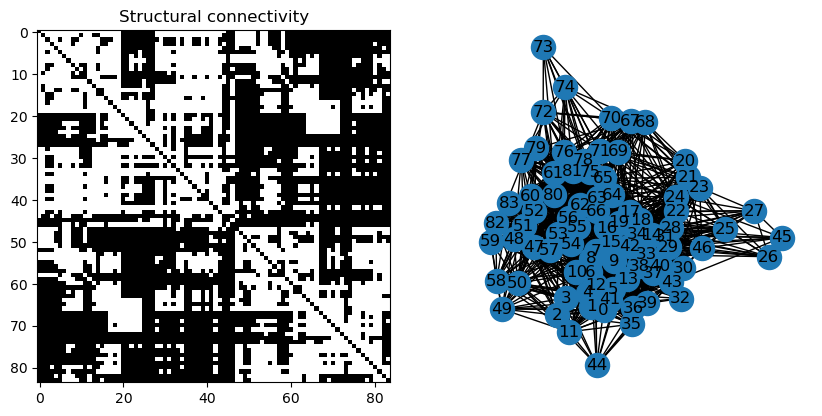

In [11]:
path_to_data = "../resources"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

filename = "adjacency_atlas.pkl"

adj = utils.load(op.join(path_to_data, filename))
# TODO + NOTE: temporary truncation to remove (by michael)
adj = adj[:84, :84] 
adj -= np.diag(np.diag(adj))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

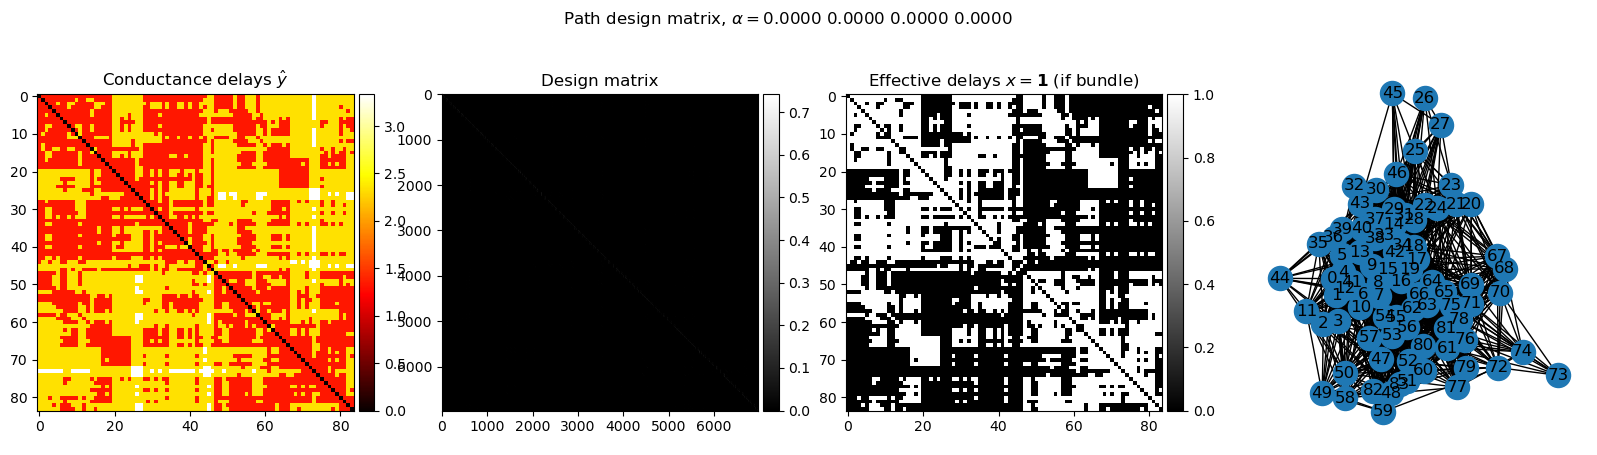

In [12]:
max_path_depth = 3

#multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

#a = 0
# Computes the alpha vector as alpha_n = a^n
#alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

#design_shortest = regmod.combine_paths_matrices(multi_hops_design, alpha=alpha)
design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=0.5)

y_pred_mat = regmod.predict_conduction_delays(design_shortest, adj, invert_weights=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(y_pred_mat, cmap='hot', interpolation=None)
axes[0].set_title("Conductance delays $\hat{y}$")
utils.add_cbar(fig, axes[0])
#utils.annotate_heatmap(fig, axes[0], y_pred_mat, adapt_color=0.6)

axes[1].imshow(design_shortest, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title("Design matrix")
utils.add_cbar(fig, axes[1])

axes[2].imshow(adj, cmap='gray')#, vmax=y_pred_mat.max())
axes[2].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[2])

nx.draw(toy_graph, ax=axes[3], with_labels=True)

### Sanity check

In [13]:
n_reduced = -1
reduced_adj = adj[:n_reduced][:, :n_reduced]

x_ground = utils.remove_diagonal_entries(reduced_adj).flatten()

a = 0.5
# Computes the alpha vector as alpha_n = a^n
alpha = solver.torch.tensor([a**(i+1) for i in range(max_path_depth)])

#design_model = solver.combine_paths_matrices_torch(solver.torch.tensor(multi_hops_design), alpha=alpha)

design_shortest = regmod.build_design_shortest(reduced_adj, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)
x_ground = utils.remove_diagonal_entries(reduced_adj).flatten()
y_pred = solver.forward(design_model, solver.torch.tensor(x_ground)).numpy()

In [14]:
y_pred = solver.forward(design_model, solver.torch.tensor(x_ground))
y_ground = solver.torch.tensor(utils.deepcopy(y_pred))

init_pseudo = False
if init_pseudo:
    x_pseudo = solver.pseudo_inverse(y_pred.numpy(), a_design=design_model.numpy())
    x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
else:
    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(x_ground))).requires_grad_(True)

/var/folders/nj/ltrlv15x5jj2jq78pbb2srz80000gn/T/ipykernel_76439/2463974400.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ground = solver.torch.tensor(utils.deepcopy(y_pred))


In [15]:
## Checking for zero entries in the y vector (conduction delays)

non_zero_mask = y_ground > 0

y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

In [16]:
importlib.reload(solver)

x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_ground, design_model,
                                            n_iter=5000, verbose=False, 
                                            early_stop=1e-10, step_size=5e-2,
                                            l2_penalty=5e-1)

  0%|          | 0/5000 [00:00<?, ?it/s]

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Estimated Effective delays w/ loss=0.3287'}>)

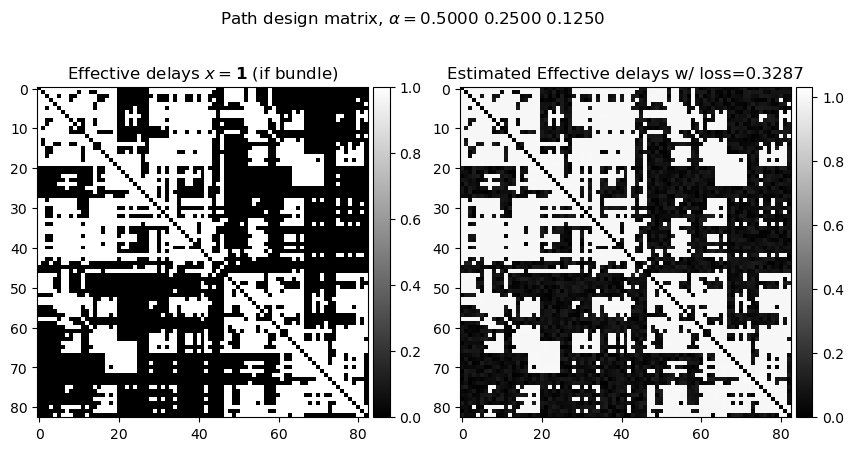

In [17]:
x_ground_mat = utils.add_diagonal_entries(x_ground.reshape(reduced_adj.shape[0], reduced_adj.shape[1]-1))
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(reduced_adj.shape[0], reduced_adj.shape[1]-1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(x_ground_mat, cmap='gray')
axes[0].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[0])
# utils.annotate_heatmap(fig, axes[0], x_ground_mat, adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title(f"Estimated Effective delays w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])
# utils.annotate_heatmap(fig, axes[1], np.round(x_pred_mat,4), adapt_color=0.6)

Text(0.5, 0, 'Delay differences')

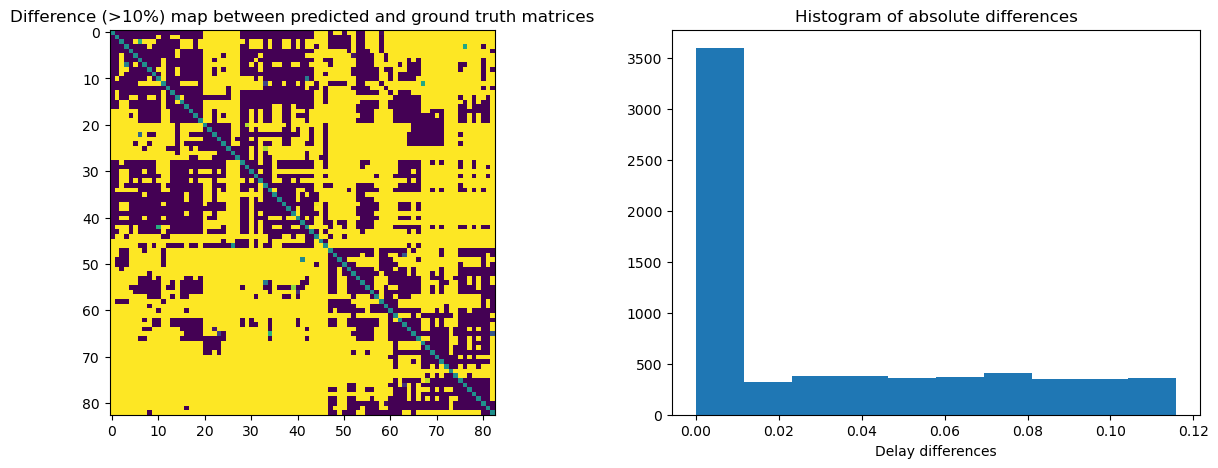

In [18]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
#ax.imshow(np.abs(x_pred_mat - x_ground_mat) > 0.1)
ax[0].imshow(x_pred_mat - x_ground_mat, vmin=-1e-5, vmax=1e-5)
ax[0].set_title('Difference (>10%) map between predicted and ground truth matrices')
ax[1].hist(np.abs(x_pred_mat - x_ground_mat).flatten())
ax[1].set_title('Histogram of absolute differences')
ax[1].set_xlabel('Delay differences')

### From conductance delay

In [19]:
n_reduced = -1

y_ground_mat = utils.load("../resources/conductance-delay_Lausanne2008_33.pkl")
y_ground_mat = np.nan_to_num(y_ground_mat['median'])[:n_reduced][:, :n_reduced]

y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

In [22]:
max_path_depth = 3

adj_reduced = adj[:n_reduced][:, :n_reduced]

a = 0.85
# Computes the alpha vector as alpha_n = a^n
alpha = [a**(i+1) for i in range(max_path_depth)]

#design_model = solver.combine_paths_matrices_torch(solver.torch.tensor(multi_hops_design), alpha=alpha).numpy()
design_shortest = regmod.build_design_shortest(adj_reduced, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)

In [23]:
## Checking for zero entries in the y vector (conduction delays)
non_zero_mask = y_ground > 0

y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

In [24]:
init_pseudo = False
if init_pseudo:
    x_pseudo = solver.pseudo_inverse(y_ground, a_design=design_model.numpy(), rcond=1e-10)
    x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
else:
    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

In [123]:
importlib.reload(solver)
x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=True, 
                                            early_stop=1e-10, step_size=5e-1, delta=10,
                                            #early_stop=1e-10, step_size=5e-1,
                                            l2_penalty=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

###### ITER 0 #######
datafit loss: 944.2303679260224
L2 norm: 47.83429872488418
positivity loss: 0.0

###### ITER 1000 #######
datafit loss: 804.3728205327149
L2 norm: 137.21100227903696
positivity loss: 0.0

###### ITER 2000 #######
datafit loss: 738.135307138512
L2 norm: 196.15216810421398
positivity loss: 0.0

###### ITER 3000 #######
datafit loss: 703.5050142127305
L2 norm: 228.5241374934521
positivity loss: 0.0

###### ITER 4000 #######
datafit loss: 685.1944144295312
L2 norm: 246.15143615857687
positivity loss: 0.0

###### ITER 5000 #######
datafit loss: 675.3800982994804
L2 norm: 255.76339596390304
positivity loss: 0.0

###### ITER 6000 #######
datafit loss: 670.0634097388212
L2 norm: 261.0165247144479
positivity loss: 0.0

###### ITER 7000 #######
datafit loss: 667.1653877733822
L2 norm: 263.89629482005915
positivity loss: 0.0

###### ITER 8000 #######
datafit loss: 665.5802364600852
L2 norm: 265.47676562464136
positivity loss: 0.0

###### ITER 9000 #######
datafit loss: 664.7

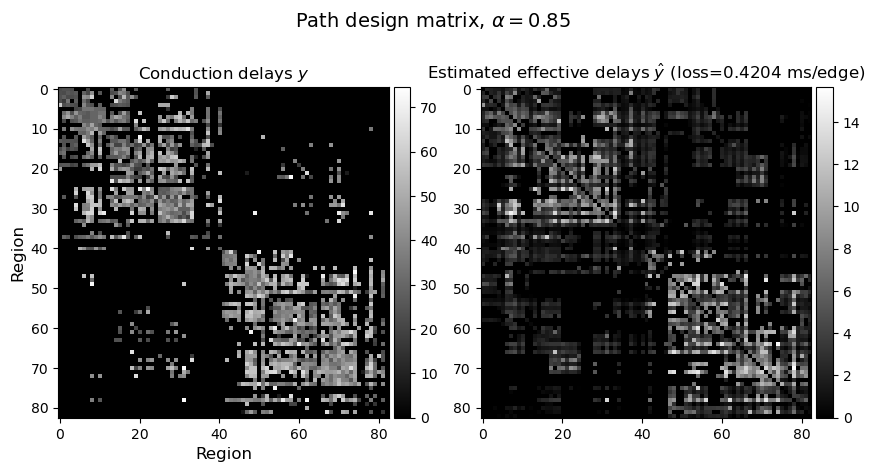

In [124]:
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj_reduced.shape[0], adj_reduced.shape[1]-1))

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha={a}$", fontsize=14)

axes[0].imshow(y_ground_mat, cmap='gray')
axes[0].set_title(f"Conduction delays $y$", fontsize=12)
axes[0].set_xlabel("Region", fontsize=12)
axes[0].set_ylabel("Region", fontsize=12)
utils.add_cbar(fig, axes[0])
# utils.annotate_heatmap(fig, axes, np.round(x_pred_mat,4), adapt_color=0.6)

prop_loss = loss / np.sum(y_ground_mat != 0)
axes[1].imshow(x_pred_mat, cmap='gray')
axes[1].set_title(f"Estimated effective delays $\hat y$ (loss={np.round(prop_loss,4)} ms/edge)", fontsize=12)
utils.add_cbar(fig, axes[1])

#axes[2].imshow(x_pred_mat, cmap='gray', vmin=0)
#axes[2].set_title(f"Clipped $\hat y$")
#utils.add_cbar(fig, axes[2])

if save_plots:
    fig.savefig(f"../figures/estimated_delays_a{a}.png", dpi=300)

In [ ]:
x = x_opt
y = y_ground

x_mask = x > 1e-5
y_mask = y != 0
xy_mask = np.logical_and(x_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,8))

#plt.scatter(y[mymask], x[mymask])
ax.scatter(y[xy_mask], x[xy_mask], s=100, alpha=.4, edgecolors="none")
ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)

ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)

if save_plots:
    fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)

In [ ]:
import seaborn as sns

cond_w_direct = x_opt[x_ground>0]
cond_wout_direct = x_opt[x_ground==0]

opt_bins = np.ceil(y_ground.max()) - np.floor(y_ground.min())
print(opt_bins)

nbins=np.arange(0, 100, 5)
nbins=np.arange(np.floor(y_ground.min()), np.ceil(y_ground.max()), 2)

sns.kdeplot(cond_w_direct[cond_w_direct>1e-5], bw_adjust=.8, fill=True, label='With direct SC')
sns.kdeplot(cond_wout_direct[cond_wout_direct>1e-5], bw_adjust=.8, fill=True, label='Without direct SC')

#plt.hist(cond_w_direct[cond_w_direct>0], bins=nbins, alpha=0.6, label='With direct SC')
#plt.hist(cond_wout_direct[cond_wout_direct>0], bins=nbins, alpha=0.6, label='Without direct SC')

plt.title("Histogram of conduction delays")
plt.xlabel("Conduction delays [ms]")
plt.legend()

#plt.savefig("../figures/hist_cond_delay.png")

#plt.boxplot([cond_w_direct[cond_w_direct>0], cond_wout_direct[cond_wout_direct>0]])
#plt.xticks([1, 2], ['Direct SC', 'No direct SC'])
#plt.ylabel('Conduction delays')

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
#ax.imshow(np.abs(x_pred_mat - x_ground_mat) > 0.1)
diff = y_ground_mat - x_pred_mat
maxval = np.abs(diff).max()

ax[0].imshow(diff, vmin=-maxval, vmax=maxval, cmap="coolwarm")
ax[0].set_title('Difference (>10%) map between predicted and ground truth matrices')
ax[1].hist(np.abs(diff).flatten())
ax[1].set_title('Histogram of absolute differences')
ax[1].set_xlabel('Delay differences')

# Visualize the influence of $\alpha$

In [ ]:
n_reduced = -1

y_ground_mat = utils.load("../resources/conductance-delay_Lausanne2008_33.pkl")
y_ground_mat = np.nan_to_num(y_ground_mat['median'])[:n_reduced][:, :n_reduced]

y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

adj_reduced = adj[:n_reduced][:, :n_reduced]

n_alphas=20
alphas = np.linspace(0, 1, n_alphas)

losses = np.zeros_like(alphas)
all_sol = np.zeros((len(alphas), adj_reduced.shape[0], adj_reduced.shape[1]))

In [ ]:
init_pseudo = False
for a_i, a in enumerate(alphas):
    if a == 0:
        design_model = solver.torch.tensor(regmod.build_design_shortest(adj_reduced, n_subopt=0, alpha=0))
    else:
        design_model = solver.torch.tensor(regmod.build_design_shortest(adj_reduced, n_subopt=1, alpha=a))

    if init_pseudo:
        x_pseudo = solver.pseudo_inverse(y_ground, a_design=design_model.numpy(), rcond=1e-10)
        x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
    else:
        np.random.seed(99)
        x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

    x = utils.deepcopy(x_init)
    x_opt, loss = solver.gradient_descent_solver(x, y_ground, design_model,
                                                n_iter=40000, verbose=False,
                                                early_stop=1e-10, step_size=5e-1)
    all_sol[a_i] = utils.add_diagonal_entries(x_opt.reshape(adj_reduced.shape[0], adj_reduced.shape[1]-1))

    y_est = design_shortest @ x_opt
    losses[a_i] = np.linalg.norm(y_est - y_ground.numpy())

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].plot(alphas, losses)
axes[0].set_title(r"Loss as a function of $\alpha$")

axes[1].imshow(y_ground_mat, cmap='gray')
axes[1].set_title(r"Original conductance delays $y$")
utils.add_cbar(fig, axes[1])

axes[2].imshow(all_sol[np.argmin(losses)], cmap='gray')
axes[2].set_title(rf"Effective delays $x^*$ for $\alpha={alphas[np.argmin(losses)]}$")
utils.add_cbar(fig, axes[2])

In [ ]:
utils.save("regressed_effective_delay_norm_alphas-05-1.pkl",
           {'alphas': alphas, 'losses': losses, 'eff_delay': all_sol})

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].imshow(all_sol[np.argmin(losses)], cmap='gray', vmin=0)
axes[0].set_title(rf"Clipped effective delays $x^*$ for $\alpha={alphas[np.argmin(losses)]}$")
utils.add_cbar(fig, axes[0])

a_mid = 3
axes[1].imshow(all_sol[a_mid], cmap='gray', vmin=0)
axes[1].set_title(rf"Clipped effective delays $x^*$ for $\alpha={alphas[a_mid]}$")
utils.add_cbar(fig, axes[1])

axes[2].imshow(all_sol[-1], cmap='gray', vmin=0)
axes[2].set_title(rf"Clipped effective delays $x^*$ for $\alpha={alphas[-1]}$")
utils.add_cbar(fig, axes[2])

# Visualize the influence of $\delta$

In [92]:
n_reduced = -1

y_ground_mat = utils.load("../resources/conductance-delay_Lausanne2008_33.pkl")
y_ground_mat = np.nan_to_num(y_ground_mat['median'])[:n_reduced][:, :n_reduced]

y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

adj_reduced = adj[:n_reduced][:, :n_reduced]

# Building the design matrix takes ~20s
alpha = 0.8
design_model = solver.torch.tensor(regmod.build_design_shortest(adj_reduced, n_subopt=1, alpha=alpha))

## Checking for zero entries in the y vector (conduction delays)
non_zero_mask = y_ground > 0
y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

In [125]:
n_deltas=5
deltamax = 10
deltas = np.linspace(0, deltamax, n_deltas, dtype=int)

losses = np.zeros_like(deltas)
all_sol = np.zeros((len(deltas), adj_reduced.shape[0], adj_reduced.shape[1]))

init_pseudo = False

for d_i, d in enumerate(deltas):

    print(f"Running delta={d} ...")

    if init_pseudo:
        x_pseudo = solver.pseudo_inverse(y_masked, a_design=design_model_masked.numpy(), rcond=1e-10)
        x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
    else:
        np.random.seed(99)
        x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

    x = utils.deepcopy(x_init)
    x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                                #n_iter=40000, verbose=False, 
                                                n_iter=20000, verbose=False, delta=d,
                                                early_stop=1e-10, step_size=5e-1)
    all_sol[d_i] = utils.add_diagonal_entries(x_opt.reshape(adj_reduced.shape[0], adj_reduced.shape[1]-1))

    perc_thresh = np.percentile(x_opt, 10)
    perc_thresh = 5
    print(f"Percentile 1 is: {perc_thresh}")
    y_est = design_model_masked @ (x_opt + (x_opt > perc_thresh) * d)
    losses[d_i] = np.linalg.norm(y_est - y_masked.numpy())

Running delta=0 ...


  0%|          | 0/10000 [00:00<?, ?it/s]

Percentile 1 is: 5
Running delta=2 ...


  0%|          | 0/10000 [00:00<?, ?it/s]

Percentile 1 is: 5
Running delta=5 ...


  0%|          | 0/10000 [00:00<?, ?it/s]

Percentile 1 is: 5
Running delta=7 ...


  0%|          | 0/10000 [00:00<?, ?it/s]

Percentile 1 is: 5
Running delta=10 ...


  0%|          | 0/10000 [00:00<?, ?it/s]

Percentile 1 is: 5


Text(0.5, 1.0, 'Loss as a function of $\\delta$')

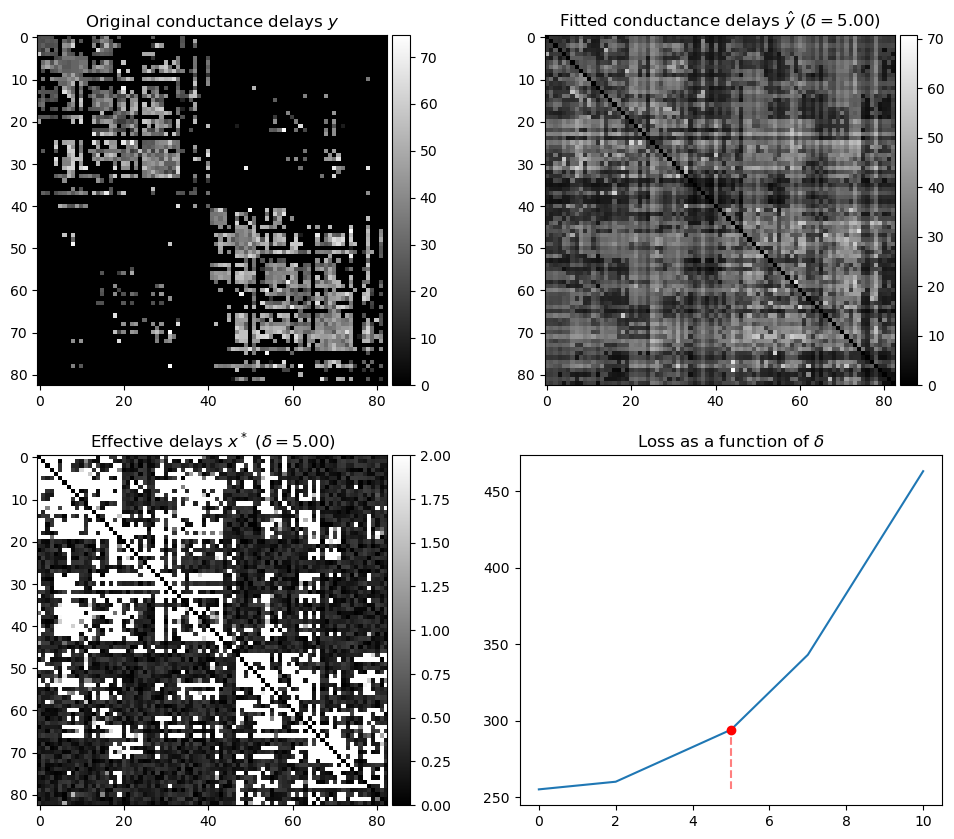

In [128]:
sol_id = np.argmin(losses)
sol_id = 2

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

axes[0, 0].imshow(y_ground_mat, cmap='gray')
axes[0, 0].set_title(r"Original conductance delays $y$")
utils.add_cbar(fig, axes[0, 0])

sol_flatten = utils.remove_diagonal_entries(all_sol[sol_id]).flatten()
y_flatten = solver.forward(design_model, solver.torch.tensor(sol_flatten + (sol_flatten > perc_thresh * deltas[sol_id]))).numpy()
predicted_y = utils.add_diagonal_entries(y_flatten.reshape(adj_reduced.shape[0], adj_reduced.shape[1]-1))

axes[0, 1].imshow(predicted_y, cmap='gray')
axes[0, 1].set_title(rf"Fitted conductance delays $\hat{{y}}$ ($\delta={deltas[sol_id]:2.2f}$)")
utils.add_cbar(fig, axes[0, 1])

axes[1, 0].imshow(all_sol[sol_id], cmap='gray', vmax=2)
axes[1, 0].set_title(rf"Effective delays $x^*$ ($\delta={deltas[sol_id]:2.2f}$)")
utils.add_cbar(fig, axes[1, 0])

axes[1, 1].plot(deltas, losses)
axes[1, 1].scatter(deltas[sol_id], losses[sol_id], color="red", zorder=2)
axes[1, 1].plot([deltas[sol_id]]*2, [losses.min(), losses[sol_id]], ls="--", color="red", alpha=.5, zorder=1)
axes[1, 1].set_title(r"Loss as a function of $\delta$")

In [ ]:
utils.save(f"regressed_effective_delay_norm_deltas-{deltas.min()}-{deltas.max()}.pkl",
           {'deltas': deltas, 'losses': losses, 'eff_delay': all_sol})

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].imshow(all_sol[np.argmin(losses)], cmap='gray', vmin=0, vmax=15)
axes[0].set_title(rf"Clipped effective delays $x^*$ for $\delta={deltas[np.argmin(losses)]}$")
utils.add_cbar(fig, axes[0])

a_mid = 3
axes[1].imshow(all_sol[a_mid], cmap='gray', vmin=0, vmax=15)
axes[1].set_title(rf"Clipped effective delays $x^*$ for $\delta={deltas[a_mid]}$")
utils.add_cbar(fig, axes[1])

axes[2].imshow(all_sol[-1], cmap='gray', vmin=0, vmax=15)
axes[2].set_title(rf"Clipped effective delays $x^*$ for $\delta={deltas[-1]}$")
utils.add_cbar(fig, axes[2])